Caroline Richards | 3688260102

In [19]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score,classification_report, confusion_matrix, log_loss, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn import svm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

In [2]:
bean_df = pd.read_csv('Dry_Bean_Dataset.csv')

# I. Aggregated Data

In [3]:
def agg_table(df, class_data, area_data):
    table = df.groupby(class_data)[area_data].agg([
        ('Average', 'mean'),('Standard Deviation', 'std'),('Count', 'count')])
    
    # Calculate the interquartile range and identify outliers
    q3, q2 = np.percentile(df[area_data], [75, 25])
    iqr = q3 - q2
    low = q2 - (1.5 * iqr)
    up = q3 + (1.5 * iqr)

    outliers = df[(df[area_data] < low) | (df[area_data] > up)]
    outliers_count = outliers.groupby(class_data).size()
    
    table['80th Confidence Interval'] = df.groupby(class_data)[area_data].agg(
        lambda x: tuple(np.percentile(x, [10, 90]))
    ).apply(lambda x: f'({x[0]}, {x[1]})')

    table['Number of Outliers'] = outliers_count

    return table

In [4]:
table=agg_table(bean_df, 'Class', 'Area')
print(table)

                Average  Standard Deviation  Count  \
Class                                                
BARBUNYA   69804.133132        10265.386454   1322   
BOMBAY    173485.059387        23327.688116    522   
CALI       75538.211043         9379.881487   1630   
DERMASON   32118.710942         4676.129470   3546   
HOROZ      53648.508817         7341.397869   1928   
SEKER      39881.299951         4779.877395   2027   
SIRA       44729.128604         4546.769886   2636   

               80th Confidence Interval  Number of Outliers  
Class                                                        
BARBUNYA             (56971.8, 82876.2)                 5.0  
BOMBAY             (144482.6, 203687.8)               522.0  
CALI                 (64454.9, 87822.9)                24.0  
DERMASON             (26091.5, 38641.5)                 NaN  
HOROZ     (43987.1, 62783.799999999996)                 NaN  
SEKER     (34416.2, 46124.200000000004)                 NaN  
SIRA             

# II. Multilinear Regression (w/ PCA)

In [5]:
X = bean_df[['Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']]
Y = bean_df['Area']

   Prior to performing a multilinear regression using principle component analysis, the X-input features are scaled with a 'scale' function to sandardize features. The data is then split into training and testing datasets using the 'train_test_split' function. This is done to ensure that the model is evaluated on independent test data. Principle component analysis is then applied separately to the training and testing sets of the X-input features. This process helps to avoid data leakage to ensure the transformation is learned primarily from the training data and that it is consistent in both sets. The PCA is performed with three components to reduce data dimensionality.

Perform multilinear regression with principal component analysis (PCA).
    
    Parameters:
    - X: Feature matrix
    - Y: Target variable
    - n_components: Number of principal components (default is 3)
    - test_size: Size of the test set during train-test split (default is 0.3)
    - random_state_cv: Random state for cross-validation (default is 263)
    - random_state_split: Random state for train-test split (default is 1385)

In [6]:
def pca_regress(X, Y, n_components, test_size, random_state_cv, random_state_split):
    plt.figure(figsize=(15, 5))
    
    # PCA Process
    pca = PCA(n_components=n_components)
    reduced_X = pca.fit_transform(scale(X))
    mse_array = []

    # k-fold cross-validation
    pca_kfold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=random_state_cv)

    # create model
    pca_model = LinearRegression()

    # cross-validation and MSE
    mse_score = -1 * cross_val_score(pca_model, reduced_X[:, :n_components], Y, cv=pca_kfold, scoring='neg_mean_squared_error').mean()
    mse_array.append(mse_score)

    # Plot cross-validation results    
    plt.subplot(1, 3, 1)
    plt.plot(mse_array)
    plt.xlabel('Number of Principal Components')
    plt.ylabel('MSE')
    plt.title('MSE vs. Principal Components')

    # Fit and transform data set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state_split)
    X_train_PCA = pca.fit_transform(scale(X_train))
    X_test_PCA = pca.transform(scale(X_test))[:, :n_components]

    # train model
    pca_model.fit(X_train_PCA[:, :n_components], Y_train)

    # make predictions
    Y_pred_PCA = pca_model.predict(X_test_PCA)

    # PCA model evaluation
    print(f'Multilinear Regression with Principle Component Analysis')
    print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(Y_test, Y_pred_PCA))}')
    print(f'R-squared: {r2_score(Y_test, Y_pred_PCA)}')

    # PCA model evaluation
    plt.subplot(1, 3, 2)
    plt.scatter(Y_test, Y_pred_PCA)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values using PCA')
    plt.title('True vs. Predicted Values using PCA')

    # Variance Ratio
    plt.subplot(1, 3, 3)
    evr = pca.explained_variance_ratio_
    cvr = evr.cumsum()
    plt.plot(range(1, n_components + 1), cvr, marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio with PCA')

    plt.show()


Multilinear Regression with Principle Component Analysis
Root Mean Squared Error: 8331.564005595914
R-squared: 0.9228713310289098


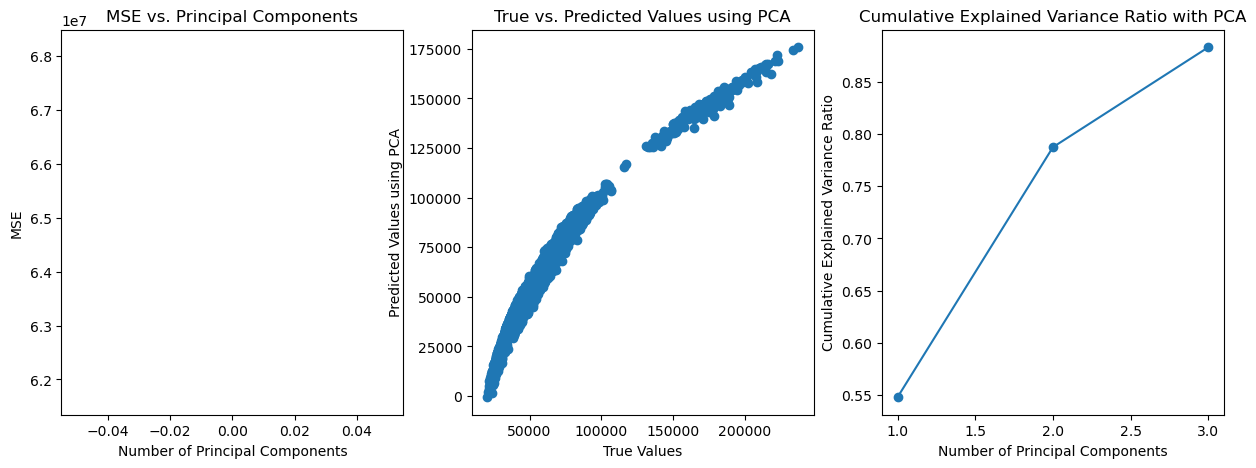

In [7]:
pca_regress(X,Y,3,0.3,263,1385)

The performance of the PCA multilinear regression is evaluated using mean squared error, cross-validation, and r-squared calculations. The root mean squared error is calculated from the square root of the mean squared error between predicted 'Area' values and test 'Area' values. It represents the average deviation between predicted and actual values. A low value of RMSE indicates better model performance suggesting that predictions are close to true values. This RMSE was calculated to be about 8331.56, which is incredibly high and not suggestive of good model performance. Conversely, the calculated r-squared value was reported to be 0.9229, which indicates a good model fit to the data. The r-squared value measures how well a model explains variance in the response variable. A value close to one indicates perfect fit while a value close to zero suggests no fit. The score of 0.9229 implies that 92.29% of the variance in 'Area' can be explained by the three principle components used in the regression model.
The far right graph shows the cumulative explaied variance ratio which plots the number of principle components against the cummulative explained variance ratio. The graph shows a steep incline from 1 to 2 and begins to level off as is rises more slowly to three principle components where the cummulative explained variance is just below 0.90. This value suggestes that three princple components captures a significant portion of the total variance, where total variance is 1.0. By using three components instead of all 16 components, the model built is able to effectively reduce dimensionality while retaining most relevant information.

# III. Multilinear Regression

In [8]:
features = ['Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity',
            'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
            'ShapeFactor3', 'ShapeFactor4']

## a. Feature Selection

For a multilinear regression analysis of the dry bean dataset with three regressors on the feature 'Area', explanatory data analysis was performed to determine the features that would create a best fit model. Initial analysis was done by creating a heatmap correlation matrix to assess which features have the highest correlation with the 'Area' feature. Additionally, this heatmap helped in assessing multicollinearity by indicating correlation between variables. The second piece of initial analysis was conducted utilizing a pair plot. Pair plots are useful for visualizing the distribution scatterplot of a single variable while also indicating relationships between two variables. The distribution can be seen on the diagonal of the pair plot while the relationships are indicated at the intersection of two variables. Between these two plots, the top three features were clearly indicated as 'Perimeter','MajorAxisLength', and 'MinorAxisLength'. Additionally, 'ShapeFactor1' showed high correlation and linearity indicative of a good feature, though not as much as the three aforementioned variables.
In the regression analysis, it will show how the residual versus fitted value plot of the initial three features has a u-shaped pattern. This is indicative of a quadratic missing from a model in order to make it a best fit. To adjust for this, the sqaured-parameters of these features were created as 'p2','maj2', and 'min2'. Fifteen combinations of all 7 features were evaluated using correlation matrix plots. These plots helped indicate where the new squared-parameters could aid in adjusting the model to eliminate multicollinearity. In assessing these models, 'p2' was determined to be too highly correlated with other features to be considered as a best fit feature. Despite the relatively higher correlation between the squared axis parameter, they proved more precise than 'p2'. These two factors combined with either 'ShapeFactor1' or 'Perimeter' were evaluated to have lower correlation between variables. All parameters chosen had a linear relationship and high correlation with 'Area'.

In [9]:
def feature_eda(features, df):

    #correlation matrix
    correlation_matrix = df[features + ['Area']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

    # pairplot (scatterplot evals)
    sns.pairplot(bean_df[features + ['Area']])
    plt.title('Feature Pair Plot')
    plt.show()
    

In [4]:
bean_df['p2'] = bean_df['Perimeter']*bean_df['Perimeter']
bean_df['maj2'] = bean_df['MajorAxisLength']*bean_df['MajorAxisLength']
bean_df['min2'] = bean_df['MinorAxisLength']*bean_df['MinorAxisLength']

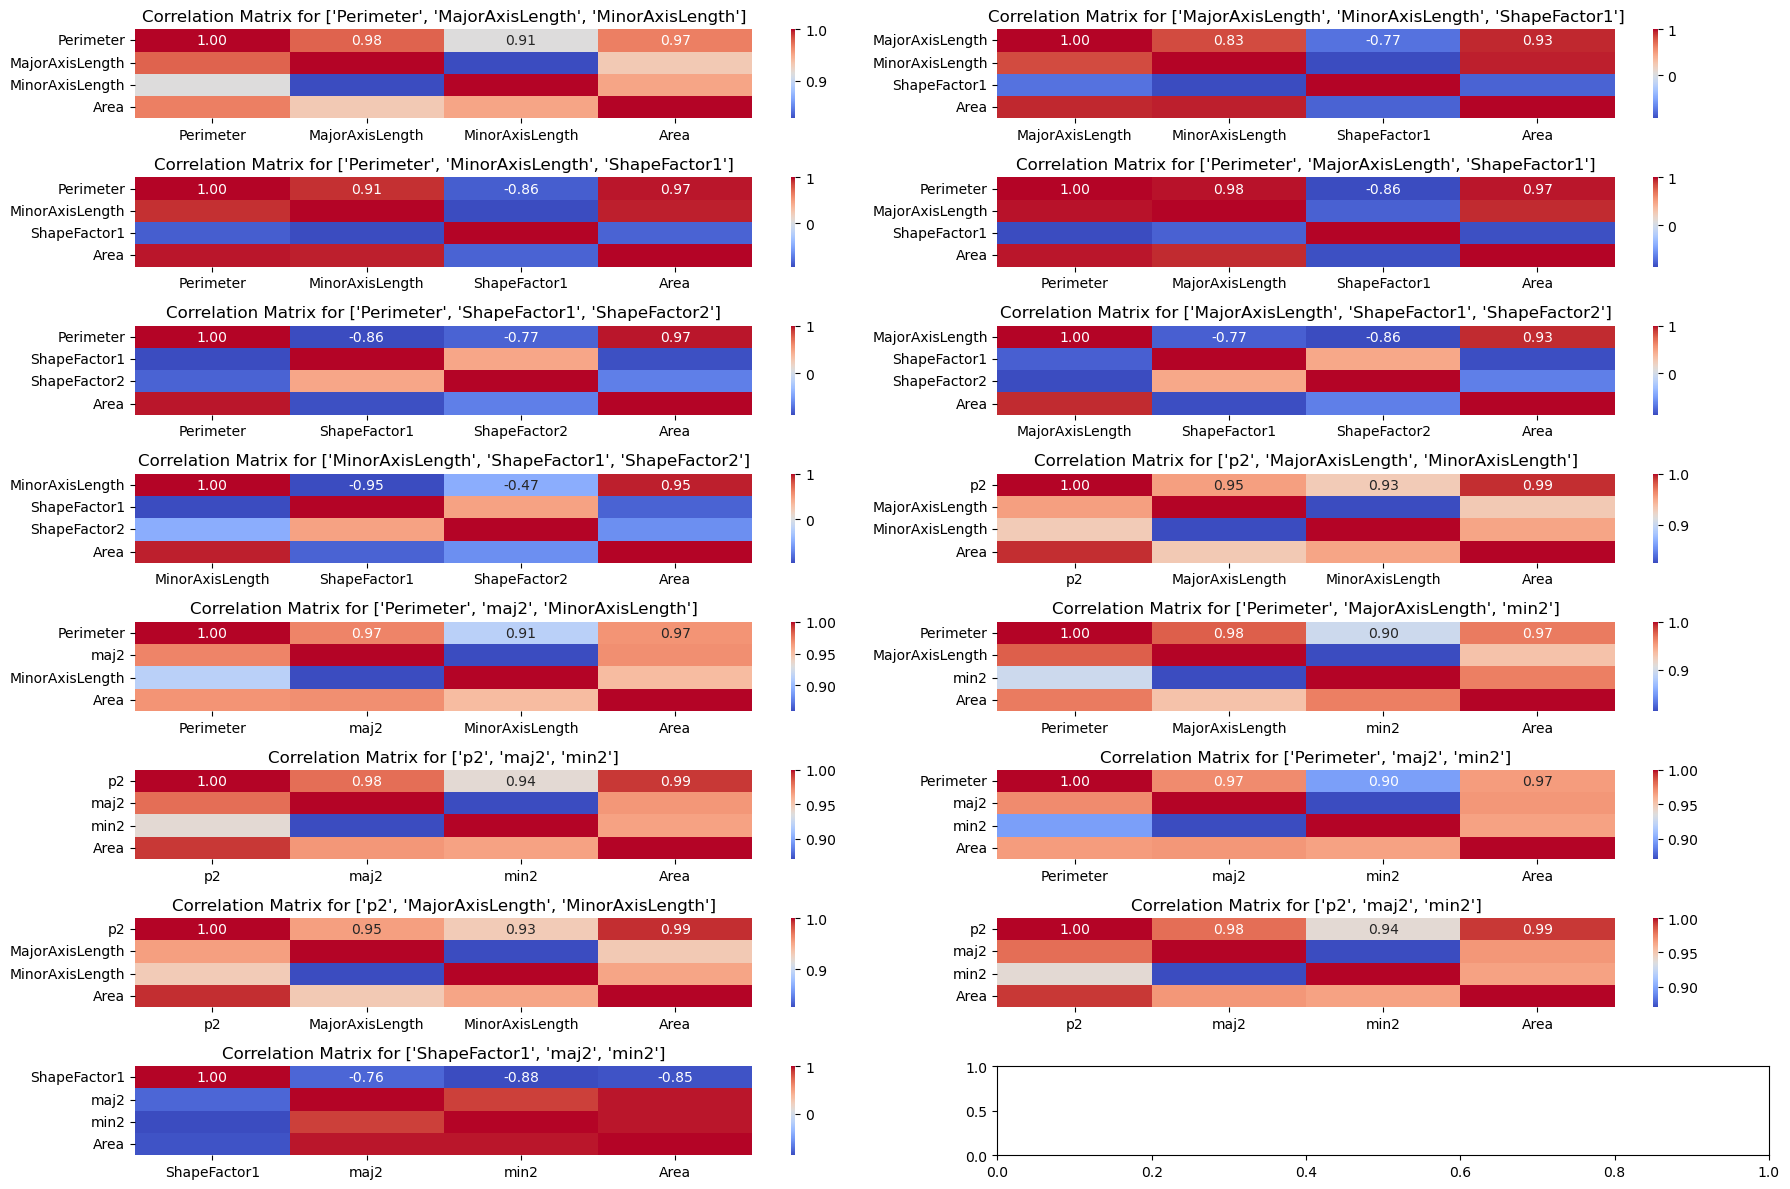

In [10]:
feat01 = ['Perimeter', 'MajorAxisLength', 'MinorAxisLength']
feat02 = ['MajorAxisLength', 'MinorAxisLength', 'ShapeFactor1']
feat03 = ['Perimeter', 'MinorAxisLength', 'ShapeFactor1']
feat04 = ['Perimeter','MajorAxisLength', 'ShapeFactor1']
feat05 = ['Perimeter', 'ShapeFactor1', 'ShapeFactor2']
feat06 = ['MajorAxisLength', 'ShapeFactor1', 'ShapeFactor2']
feat07 = ['MinorAxisLength', 'ShapeFactor1', 'ShapeFactor2']
feat08 = ['p2', 'MajorAxisLength', 'MinorAxisLength']
feat09 = ['Perimeter', 'maj2', 'MinorAxisLength']
feat10 = ['Perimeter', 'MajorAxisLength', 'min2']
feat11 = ['p2', 'maj2', 'min2']
feat12 = ['Perimeter', 'maj2', 'min2']
feat13 = ['p2', 'MajorAxisLength', 'MinorAxisLength']
feat14 =['p2', 'maj2', 'min2']
feat15 = ['ShapeFactor1', 'maj2', 'min2']
feats = [feat01,feat02,feat03,feat04,feat05,feat06,feat07,feat08,feat09,feat10,feat11,feat12,feat13,feat14,feat15]

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(18, 12))

for i, feat in enumerate(feats):
    row, col = divmod(i, 2)
    ax = axes[row, col]

    correlation_matrix = bean_df[feat + ['Area']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_title(f'Correlation Matrix for {feat}')

plt.tight_layout()
plt.show()
    

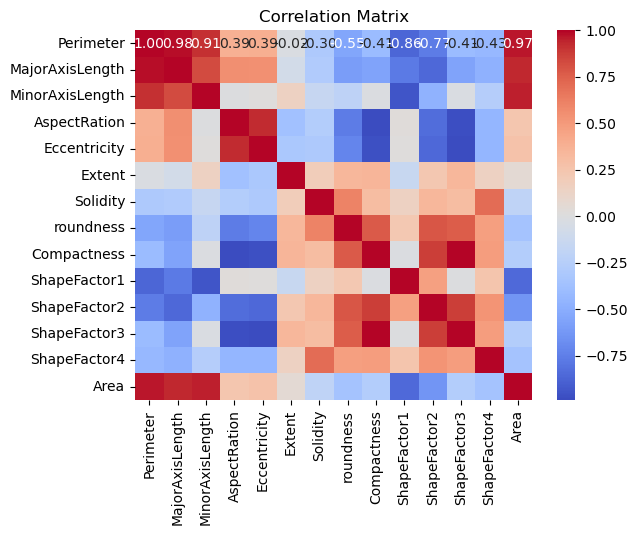

C:\Users\richa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\richa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\richa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\richa\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

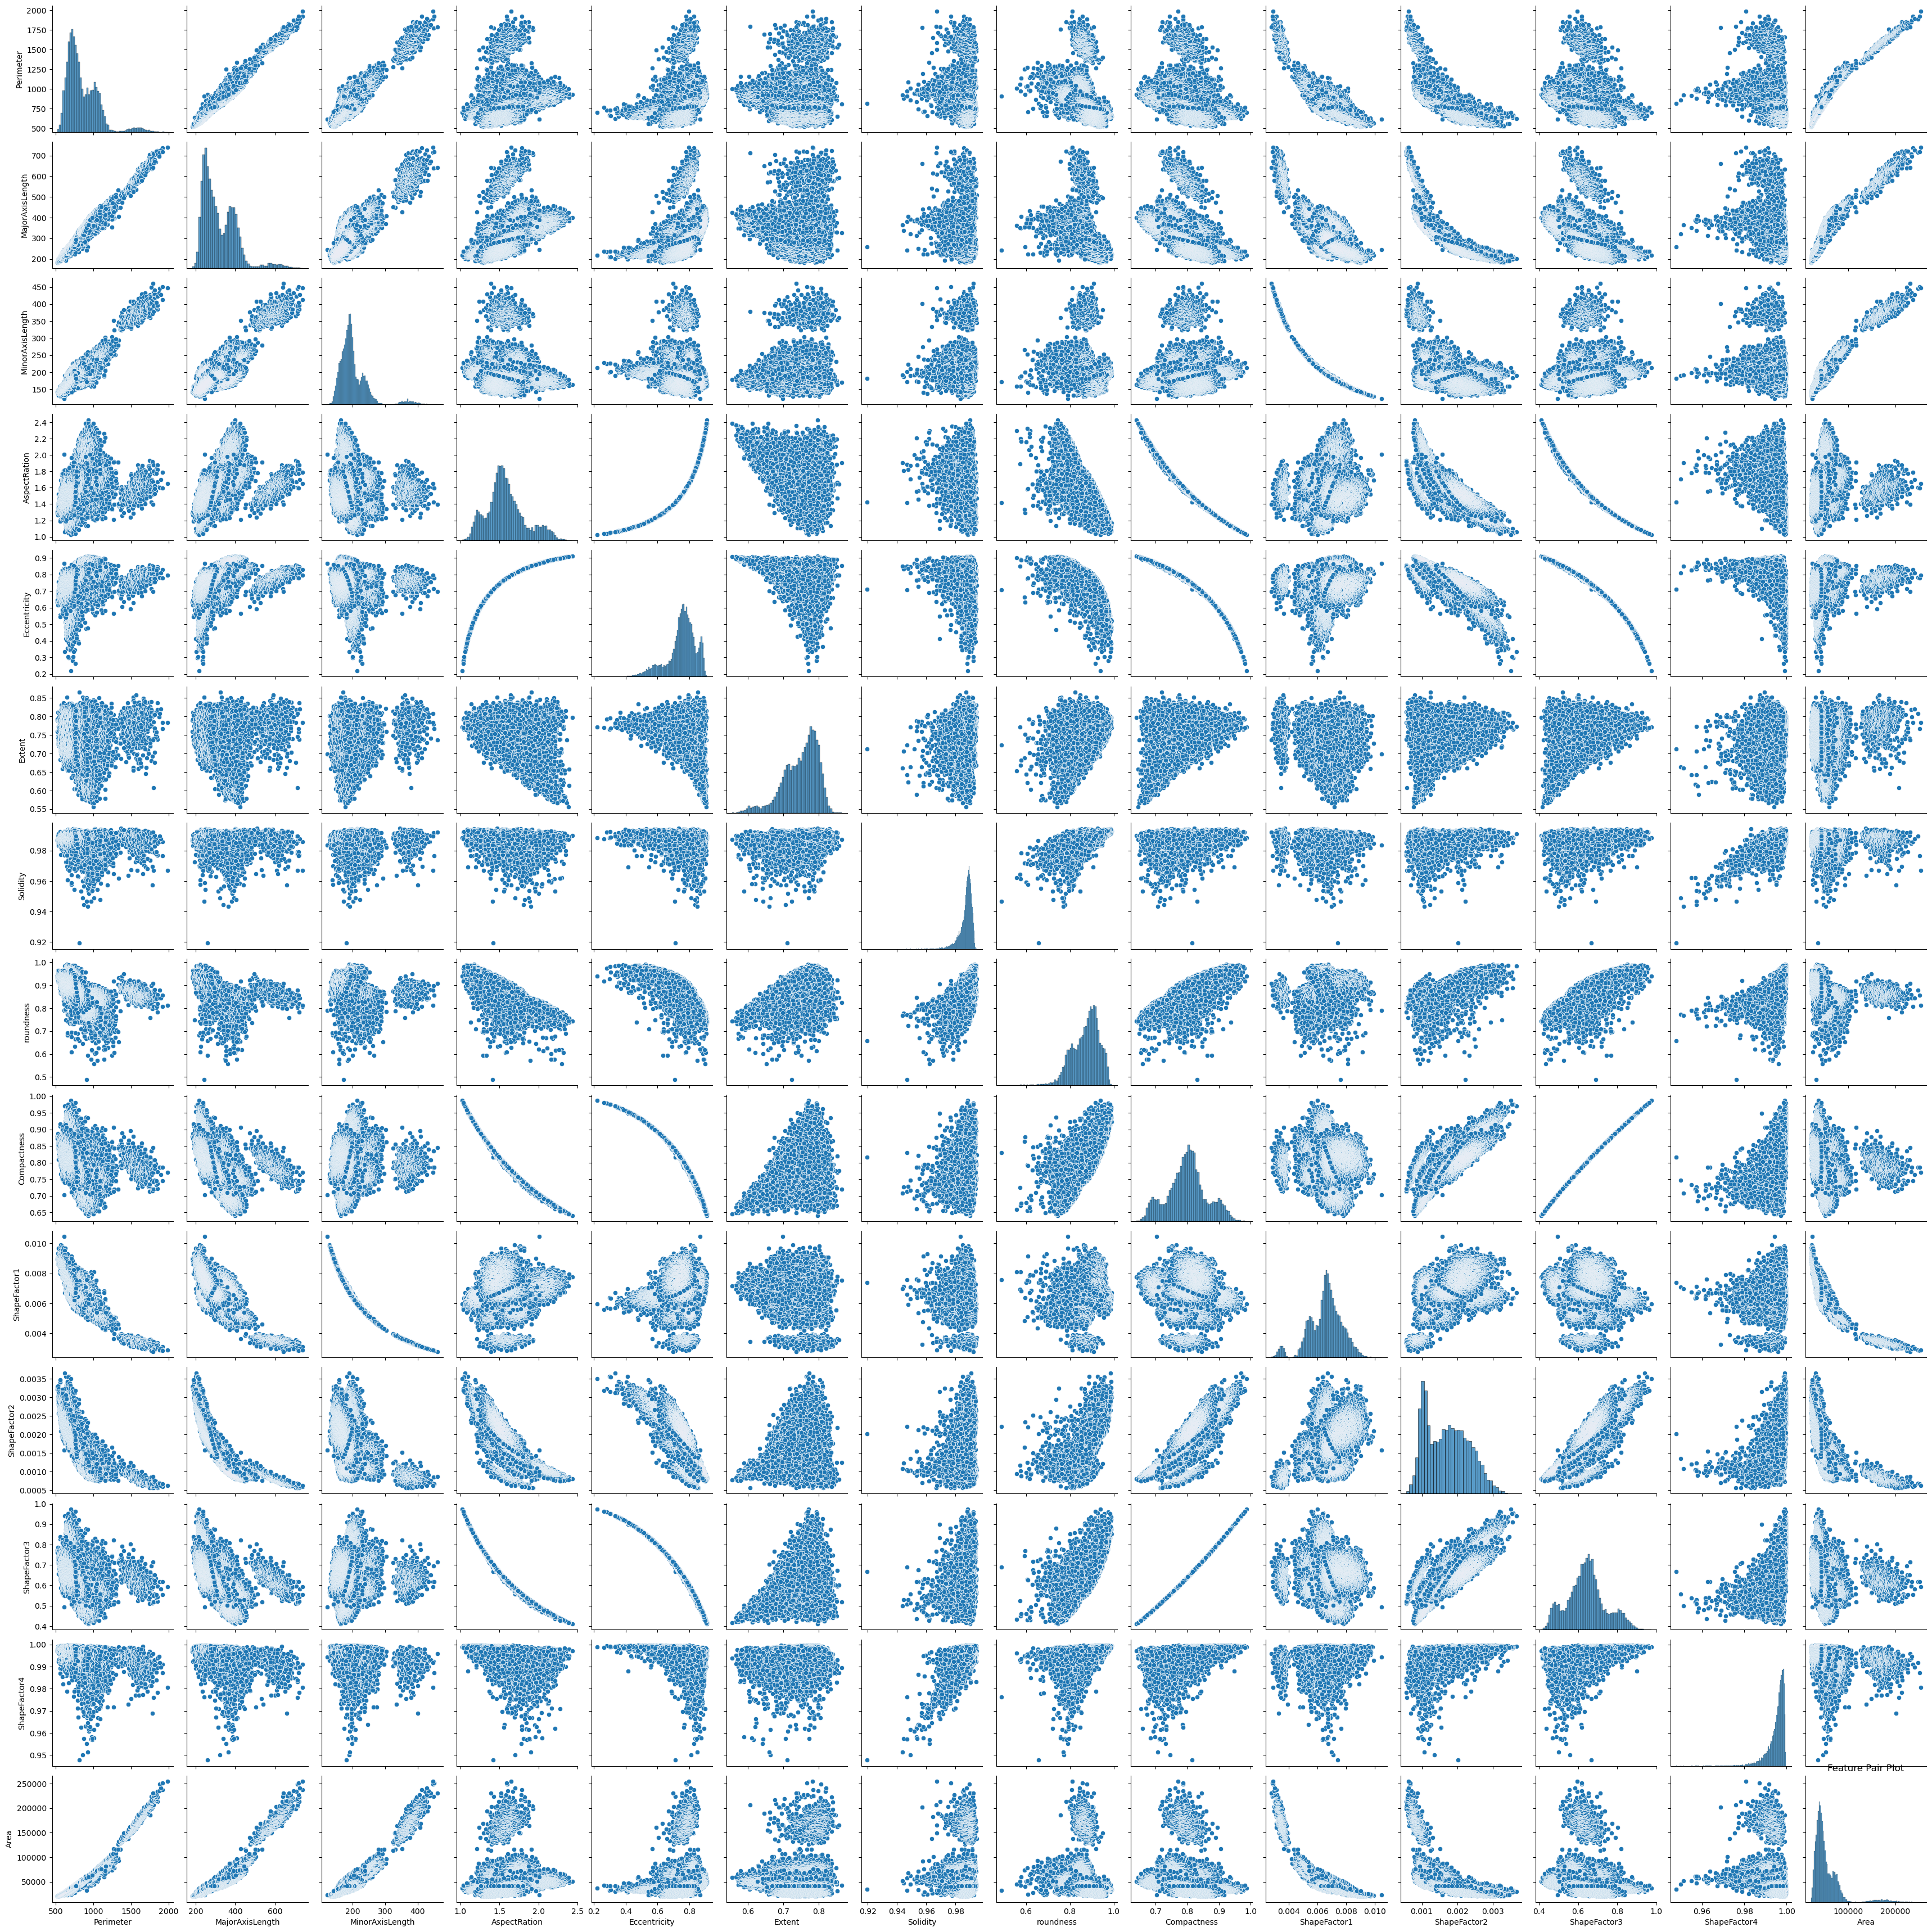

In [12]:
feature_eda(features, bean_df)

## b. Regression & Analysis

In [13]:
multi_X01 = bean_df[['Perimeter','MajorAxisLength', 'MinorAxisLength']]
multi_X12 = bean_df[['Perimeter','maj2', 'min2']]
multi_X15 = bean_df[['ShapeFactor1','maj2', 'min2']]
multi_Y = bean_df['Area']

In [14]:
def nopca_model(X, Y, features):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=165)

    multi_model = LinearRegression()
    multi_model.fit(X_train, Y_train)

    Y_pred = multi_model.predict(X_test)
    multi_coef = multi_model.coef_
    multi_int = multi_model.intercept_

    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    residuals = Y_test - Y_pred
    plt.scatter(Y_pred, residuals)
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Fitted Values Plot')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.show()

    print(f'Multilinear Regression Model of Area on 3 Features')
    print(f'Mean Absolute Error: {mean_absolute_error(Y_test, Y_pred)}')
    print(f'Mean Squared Error:{mean_squared_error(Y_test, Y_pred)}')
    print(f'R-squared: {r2_score(Y_test, Y_pred)}')
    print(f'')
    print(f'Model:')
    for i, coef in enumerate(multi_coef):
        print(f'Coefficient for feature{i + 1}: {coef}')
    print(f'Intercept: {multi_int}')
    print(f'')
    print(vif_data)

    # Create subplots for each feature
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    # Map Each Feature
    for i, feature in enumerate(features):
        axes[i].scatter(X_test[feature], Y_test, color='blue', label='Actual')
        axes[i].scatter(X_test[feature], Y_pred, color='pink', label='Predicted')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Area')
        axes[i].set_title(f'Regression Line and Predictions - {feature}')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

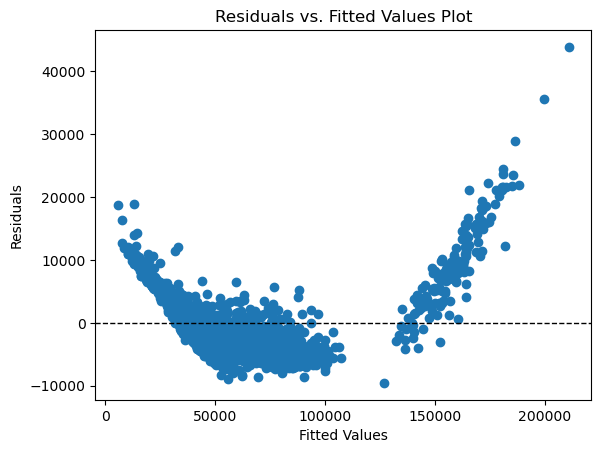

Multilinear Regression Model of Area on 3 Features
Mean Absolute Error: 3398.919832402822
Mean Squared Error:20399864.28845451
R-squared: 0.9744083380688644

Model:
Coefficient for feature1: -70.02012188998692
Coefficient for feature2: 280.06453403135833
Coefficient for feature3: 487.75681060121343
Intercept: -75372.73986023571

           Feature          VIF
0        Perimeter  1637.352777
1  MajorAxisLength   759.274058
2  MinorAxisLength   239.257595


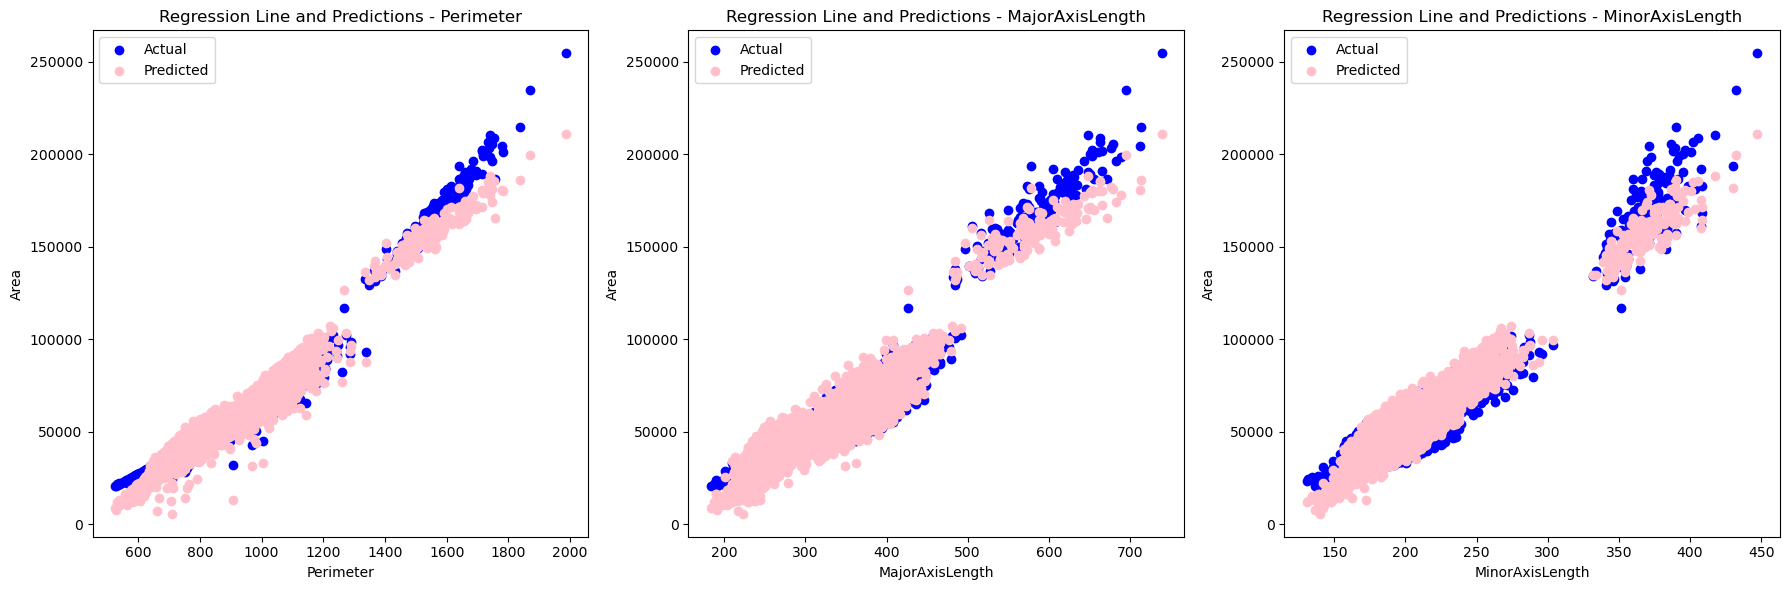

In [15]:
nopca_model(multi_X01, multi_Y, feat01)

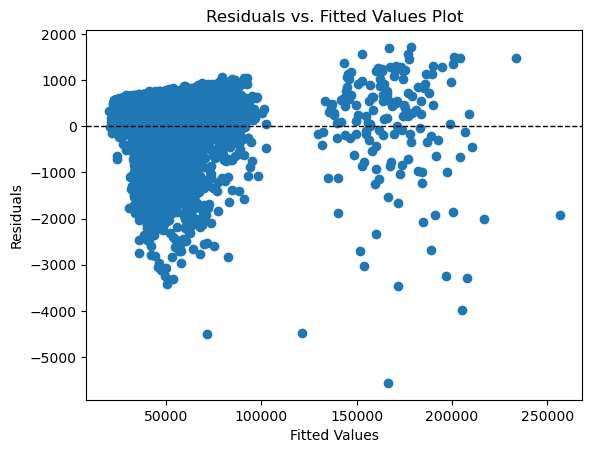

Multilinear Regression Model of Area on 3 Features
Mean Absolute Error: 600.9034459926833
Mean Squared Error:587292.0395989496
R-squared: 0.999263241209856

Model:
Coefficient for feature1: 0.46651327787555813
Coefficient for feature2: 0.2345308178995791
Coefficient for feature3: 0.6403302229339813
Intercept: -601.5382893491769

     Feature        VIF
0  Perimeter  13.967410
1       maj2  17.980450
2       min2  19.872513


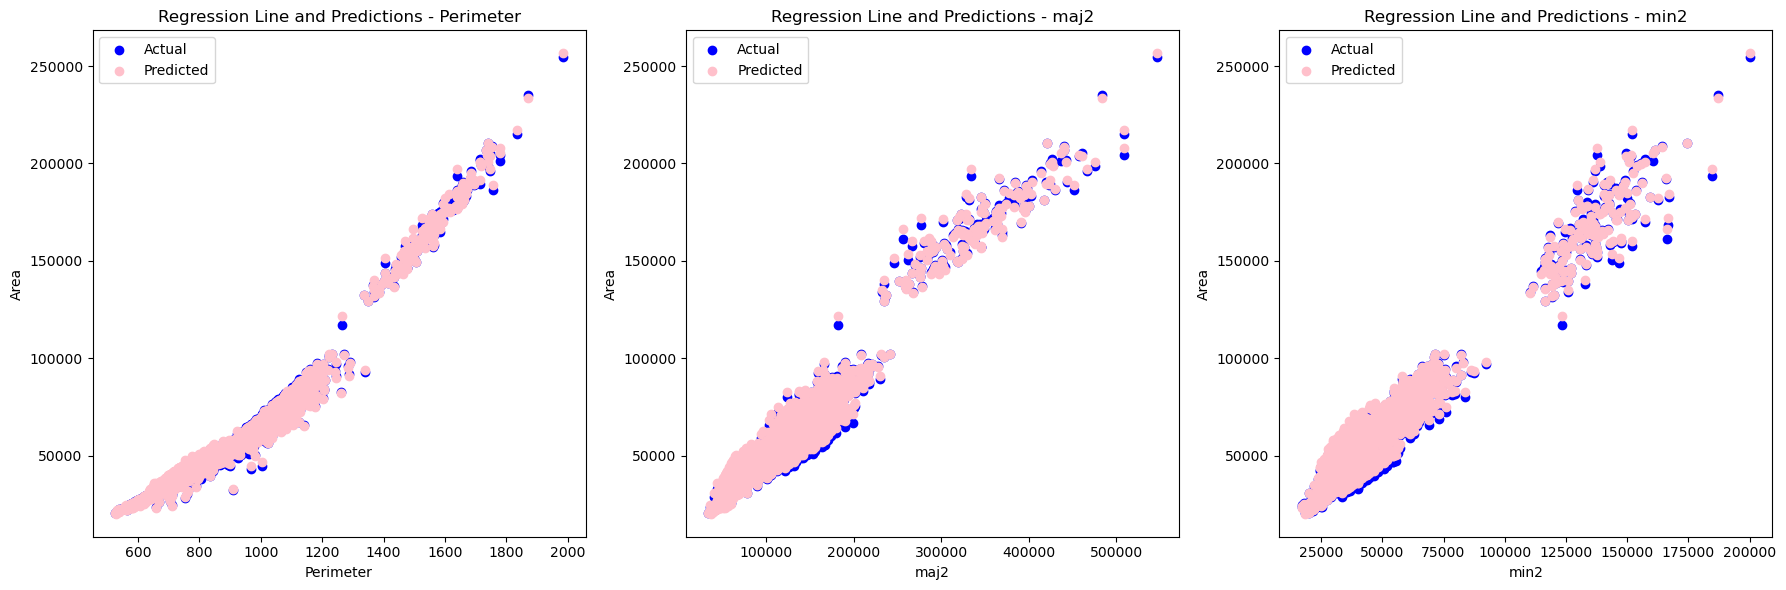

In [16]:
nopca_model(multi_X12, multi_Y, feat12)

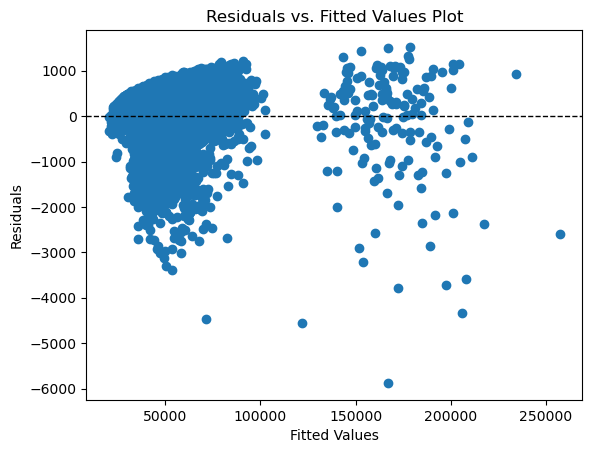

Multilinear Regression Model of Area on 3 Features
Mean Absolute Error: 588.5440276771878
Mean Squared Error:579691.5522798996
R-squared: 0.9992727760331876

Model:
Coefficient for feature1: 176620.90685484713
Coefficient for feature2: 0.2356815370198214
Coefficient for feature3: 0.6488567756288683
Intercept: -1854.3649250166345

        Feature        VIF
0  ShapeFactor1   2.755550
1          maj2  15.593012
2          min2  16.908649


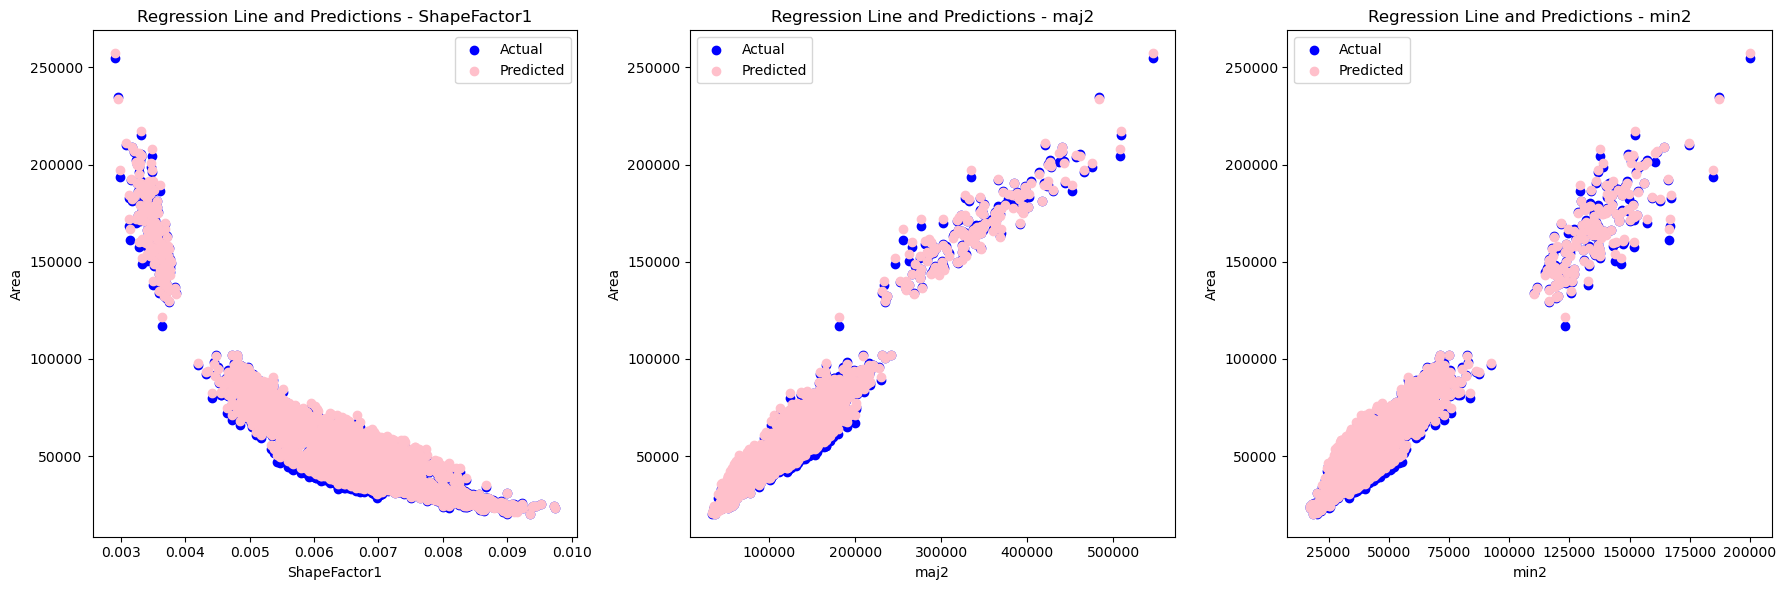

In [17]:
nopca_model(multi_X15, multi_Y, feat15)

The first model was a multilinear regression of 'Perimeter', 'MajorAxisLength', and 'MinorAxisLength' on 'Area': Area = -75372.74 -70.02Perimter + 280.06MajorAxisLength + 487.76MinorAxisLength. The r-squared value was high for this model with a score of 0.9744, but the vaariable inflation factors were quite large indicating high probability of multicollinearity while the u-shaped residual versus fitted value plot indicating potential issues with model fit. 
     Based on the u-shaped residual plot in the first model, three features were added to the data frame: 'p2' as the square of 'Perimeter', 'maj2' as the square of 'MajorAxisLength', and 'min2' as the square of 'MinorAxisLength'. These three original features were squared based on the high correlation with 'Area'. 
     The second model regressed 'Perimeter', 'maj2', and 'min2' on 'Area': -601.54 + 0.47Perimeter + 0.23maj2 + 0.64min2. The r-quaared value for this model was quite high with a score of 0.9993. The variable inflation factors for each feature were much lower than the first model, but all were still over a value of 10 which is a marker for possible multicollinearity. The residual plot for this model had a slight yet very wide-set cone-shape which could be indicative of heteroscedasticity in the model. Heteroscedasticity is a measure of error variance that causes confidence intervals and hypothesis testing to become unreliable. Heteroscedasticity causes estimators to lose their qualification as best linear unbiased estimators. Fortunatey, this is has more serious consequences when performing ordinary least squares regression rather than linear regression.
     In the third model, 'ShapeFactor1' is introduced based on its higher correlation with 'Area' (although not as high as previous features). This model regressed 'ShapeFactor1', 'maj2', nd 'min2' on 'Area': Area = -1854.36 + 176620.91 + 0.24maj2 + 0.65min2. The r-squared for this model was also quite high with a score of 0.9993. Additionally, the variance inflation factors were relatively lower than previous models with "ShapeFactor1' having a value of 2.76 indicating little to no probability of multicollinearity, yet 'maj2' and 'min2' had VIF values between 15 to 17 indicating slightly higher chance of multicollinearity for these features.
     All models have high r-squared vallues indicating strong fit to data, but Model 2 and Model three had considerably lower mean absolute error and mean squared error compared to the first model, indicating a better predictive performance of the regression model. The second model had lower overall variance inflation factors indicating lower multicollinearity among features. The second and third models show better performance in terms of accuracy and multicollinearity.

# IV. Study of Multiclass Learners

In [5]:
learner_df = bean_df.drop(['p2','maj2','min2'], axis=1)

In [6]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

## a. Random Forest Classifer

The first learner model chosen was Random Forest. Random Forest is an ensemble learning method composed of multiple decision trees which returns the classification that is most or the average regression prediction of each individual tree. Each tree node has a random subset of features taken into consideration for splitting just as done in decision tree learning. Predictions from each tree are regressed to calculate the average as the final prediction. 
     This learner was chosen due to its robustness and ability to handle non-linear relationships. Additionally, the random forest classifier has the ability to resist the problem of overfitting of data. Random Forest classification is a classic learning model that can be improved and optimized by tuning its hyperparameters like the number of estimators. This learner was tested with 50, 100, 150, 200, and 250 estimators or number of trees in the forest. To assess the perforamnce of each amount of estimators, the cross-validation score was calculated. The optimal value of estimators was determined to be 200 where cmean accuracy peaked at 0.610 with a standard deviation of 0.178.

In [20]:
def rfc_model(df):
    X = df.drop('Class', axis = 1)
    Y = df['Class']

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 54)

    rfc = RandomForestClassifier(n_estimators = 200, random_state = 54)
    rfc.fit(X_train, Y_train)

    Y_pred = rfc.predict(X_test)
    Y_prob = rfc.predict_proba(X_test)
    
    #Evaluation of Performance
    print(f'Random Forest Classifier Evaluation')
    print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
    print(f'Mean Accuracy: {np.mean(cross_val_score(rfc, X_train, Y_train, cv=kfold)):.2f}')
    print(f'Log-Loss: {log_loss(Y_test, Y_prob)}')
    print(f'Classification Report:\n', classification_report(Y_test, Y_pred))
    

    #Feature Importance
    feat_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': rfc.feature_importances_})
    feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)
    print(feat_imp_df)

    print(f'\n')

    print(f'Confusion Matrix:\n', ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred)).plot())

Random Forest Classifier Evaluation
Accuracy: 0.9177277179236043
Mean Accuracy: 0.92
Log-Loss: 0.31516413776851965
Classification Report:
               precision    recall  f1-score   support

    BARBUNYA       0.92      0.90      0.91       370
      BOMBAY       1.00      1.00      1.00       164
        CALI       0.93      0.92      0.92       486
    DERMASON       0.92      0.92      0.92      1047
       HOROZ       0.95      0.94      0.95       594
       SEKER       0.94      0.94      0.94       623
        SIRA       0.86      0.86      0.86       800

    accuracy                           0.92      4084
   macro avg       0.93      0.93      0.93      4084
weighted avg       0.92      0.92      0.92      4084

            Feature  Importance
14     ShapeFactor3    0.103335
11      Compactness    0.101682
1         Perimeter    0.098278
12     ShapeFactor1    0.097411
2   MajorAxisLength    0.081874
3   MinorAxisLength    0.072352
6        ConvexArea    0.060747
4      A

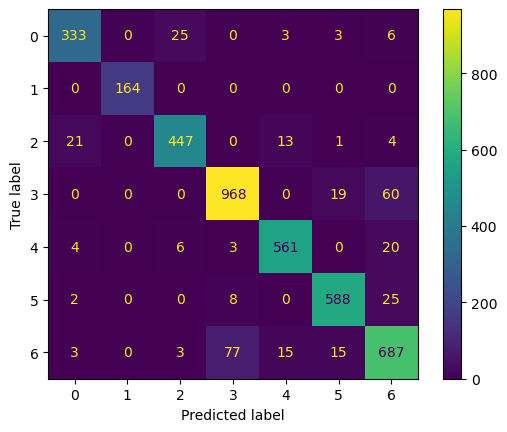

In [21]:
rfc_model(learner_df)

The overall accuracy of the Random Forest Classifier is approximately 91.77%, indicating that about 91.77% of instances are correctly classified by the model. The mean accuracy across classes is 92%, suggesting good model performance across all classes. The log-loss calculation was conducted to evaluate which probability the algorithm associates with true-outcomes. This model has a log-loss of 0.315, which is moderate because it is fairly low. The classification report table provides precision, recall, and F1-scores for each class. The precision score measures the ratio of correctly predicted positive obervations as compared to the total predicted positives. The recall score measures the ratio of correctly predicted positive observations to all observations in the actual class. The F1-score is used to measure the weighted average of the precision and recall scores for each class. In this random forest model, the high values for precision, recall, and F1-scores indicate that the model performs well across various classes.
     The feature importance gives insight into which features are contributing the most to model prediction. The importance scores here indicate that the three most influential parameters in this model are 'ShapeFactor3', 'Compactness', and 'Perimeter'.
     The confusion matrix represents the performance of the classification model with each of the 7 classes: Barbunya (0), Bombay (1), Cali (2), Dermason (3), Horoz (4), Seker (5), Sira (6).  The model appears to have a perfectly precise classification for Bombay beans, but it appears to struggle with differntiating Dermason and Sira beans. Overall, the confusion between classes is low indicating good model performance.

## b. Support Vector Machine

Support vector machines are a supervised learning algorithm for classification and regression. SVMs use a hyperplane to best separate data into classes. Labeled training examples are separated into two classes represented as a vector in a multi-dimensional feature space where the dimensions are determined by the number of features. The hyperplane decision boundary is a sixteen-dimensional boundary called the maximum-margin hyperplane for its purpose to maximally separate different classes. The goal of an SVM is to maximize the margin or distance between the hyperplane and the nearest data point from each class. These data points are called support vectors. Support vector machines are based on the mathematical optimization theory. The optimization problem is formulated to maximize margin while minimizing classification error. The objective function is utilized to calculate weights and biases to define the hyperplane. Kernel functions, such as linear, polynomial, or sigmoid , are used to map data in higher dimensional spaces so the hyperplane can separate data effectively. SVMs also utilize a regularization parameter to balance the trade-off beteen margin size and classification error minimization, where a small value allows for a wider margin but might misclassify and vice versa. The SVM training process finds optimal parameters from weights and biases that define the hyperplane through an optimization algorithm that utilizes techniques like gradient descent.
SVMs are high-dimensional spaces that are ideal for handling variable relationships, especially when they are non-linear. As indicated by the pair plot in feature selection of the regression model, many of the variable relationships for the dry bean dataset are non-linear and show no pattern. Support vector machines are ideal for handling these non-linear relationships and they are particularly useful when the dimensions are greater than the samples. Due to the powerful nature of SVMs, more computational resources are required and hyperparameters must be set. 
In this model hyperparameters were set fo kernel function and probability. The kernel function was set as 'poly' for the nature of the datset and its 16 features. Probability was set to 'True' to support log-loss evaluation analysis. Using a training dataset to fit the SVM model allows it to learn the decision boundary that separtes different classes by features.

In [11]:
def svm_model(df):
    X = df.drop('Class', axis = 1)
    Y = df['Class']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 167)
    
    svm_model = svm.SVC(kernel='poly', probability=True)
    svm_model.fit(X_train, Y_train)

    #Evaluation
    Y_pred = svm_model.predict(X_test)
    Y_prob = svm_model.predict_proba(X_test)

    print(f'Support Vector Machine Evaluation')
    print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
    print(f'Mean Accuracy: {np.mean(cross_val_score(svm_model, X_train, Y_train, cv=kfold)):.2f}')
    print(f'Log-Loss: {log_loss(Y_test,Y_prob)}')
    print(f'Classification Report:\n', classification_report(Y_test,Y_pred))
    print(f'Confusion Matrix:\n')
    ConfusionMatrixDisplay(confusion_matrix(Y_test,Y_pred)).plot()

Support Vector Machine Evaluation
Accuracy: 0.6341821743388835
Mean Accuracy: 0.63
Log-Loss: 0.8194119087118075
Classification Report:
               precision    recall  f1-score   support

    BARBUNYA       0.45      0.26      0.33       405
      BOMBAY       1.00      0.99      1.00       158
        CALI       0.62      0.73      0.67       478
    DERMASON       0.75      0.88      0.81      1046
       HOROZ       0.62      0.59      0.61       601
       SEKER       0.41      0.28      0.33       610
        SIRA       0.58      0.67      0.62       786

    accuracy                           0.63      4084
   macro avg       0.63      0.63      0.62      4084
weighted avg       0.61      0.63      0.62      4084

Confusion Matrix:



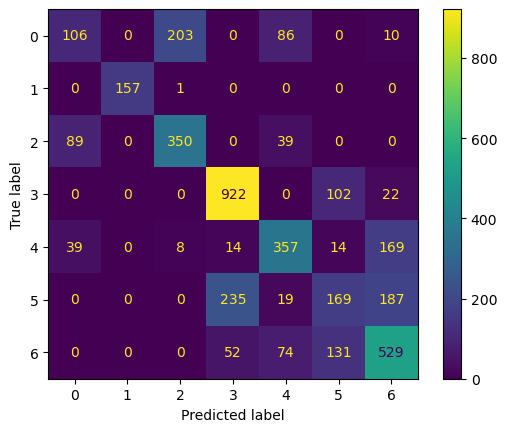

In [12]:
svm_model(learner_df)

The Support Vector Machine was evaluated for accuracy and log-loss. Additionally, performance of the model particular to each class was evaluated utilizing a confusion matrix as well as precision, recall, an F1-scores. This model was evaluated to be a poor choice for classifying the dry bean dataset. The SVM model's accuracy was fairly low at about 63.42% with a mean accuracy of 63%. Additionally, the log-loss calculation was reported at about 0.8194. This log-loss score is very high and indicates that the predicted probabilities tend to mismatch with the true probabilities of the classification outcomes. While precision, recall, and F1-scores were relatively low for the majority of features, Bombay beans, like in other algorithms, were still at a near perfect predicition in this model. Contradictory to other algorithms, the SVM model was better at identifying Dermason beans. Rather than having high confusion with Sira beans, Dermason beans had a higher rate of confusion with Seker beans. The confusion matrix overall indicates a high rate of confusion for Sira beans , as well as most of the other bean classes. Overall, the support vector machines learner is not a preferred model for bean classification.

## c. Extreme Gradient Boost Classifier

Gradient boosting algorithms are powerful classifiers than are capable of capturing complex relationships in a dataset. Boosting is an ensemble learning technique combined with weak learners to improve strength through iteraction and error correction. Gradient boosting, models are built  and corrected as the algorithm progresses. It minimizes loss by adding weak learners with weights proportional to error contribution. Extreme Gradient Boost or XGBoost uses decision trees as a base learner. It also implements the objective function, a combition of the loss function and the regularization terms, L1 (Lasso) and L2(Ridge), to optimize model training. The loss function is a measure of model performance and the regularization terms prevents overfitting by penalizing for complexity. The XGBoost process prunes decision trees during training to remove nodes who cotribution is  insignificant to improvements in the loss function, helping to control the trees complexity to avoid overfitting. Additionally, XGBoost incorporates feature importance scores to measure feature contribution and aid in feautre selection. XGBoost is effiecnt and has an overall high performance. It is a computationally efficient learning method that utilizes both parallel and distributed computation to be able to handle large datasets in a shorter period of time. XGBoost also implements early stopping to halt the training process when performance ceases to improve. Overall, XGBoost is a sufficient model for building accurate and efficient predictive models.

In [39]:
def xgboost_model(df):
    X = df.drop('Class', axis=1)
    Y = df['Class']
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size = 0.3, random_state = 235)

    xg_model = XGBClassifier(n_estimators=200, learning_rate = 0.1, max_depth=3, random_state = 78)
    xg_model.fit(X_train, Y_train)

    Y_pred = xg_model.predict(X_test)

    # Model Evaluation
    print(f'Extreme Gradient Boost Evaluation')
    print(f'Accuracy: {accuracy_score(Y_test,Y_pred)}')
    print(f'Mean Accuracy: {np.mean(cross_val_score(xg_model, X_train, Y_train, cv=kfold)):.2f}')
    print(f'Log-Loss: {log_loss(Y_test,xg_model.predict_proba(X_test))}')
    print(f'Classification Report:\n', classification_report(Y_test,Y_pred))
    print('\nFeature Importance:\n', dict(zip(X.columns, xg_model.feature_importances_)))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax0 = axes[0]
    ax0.set_title('Feature Importance')
    plot_importance(xg_model, ax=ax0)
    ax1 = axes[1]
    ax1.set_title('Confusion Matrix')
    ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred)).plot(ax=ax1)

    plt.show()

Extreme Gradient Boost Evaluation
Accuracy: 0.9311949069539667
Mean Accuracy: 0.92
Log-Loss: 0.1797140358149529
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       381
           1       1.00      1.00      1.00       149
           2       0.95      0.95      0.95       482
           3       0.91      0.93      0.92      1059
           4       0.96      0.96      0.96       556
           5       0.98      0.95      0.96       630
           6       0.88      0.87      0.88       827

    accuracy                           0.93      4084
   macro avg       0.94      0.94      0.94      4084
weighted avg       0.93      0.93      0.93      4084


Feature Importance:
 {'Area': 0.13475688, 'Perimeter': 0.07583694, 'MajorAxisLength': 0.07322776, 'MinorAxisLength': 0.103651464, 'AspectRation': 0.012108014, 'Eccentricity': 0.0, 'ConvexArea': 0.15985188, 'EquivDiameter': 0.0, 'Extent': 0.004394944, 'Solidity': 0.0

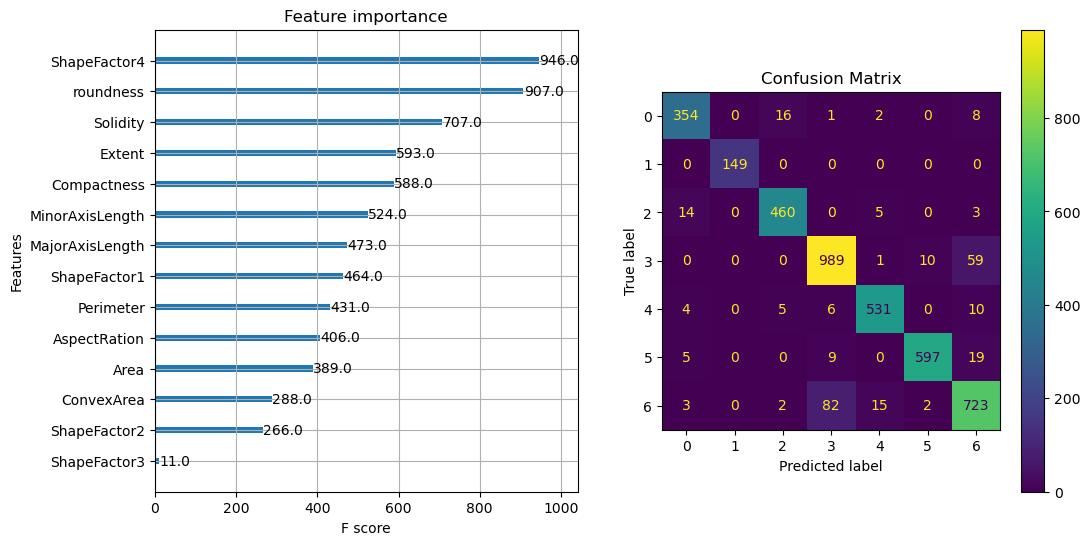

In [40]:
xgboost_model(learner_df)

The overall accuracy of the Extreme Gradient Boost Classifier is approximately 93.12%, indicating that about 93.12% of instances are correctly classified by the model. The mean accuracy across classes is 92%, suggesting good model performance across all classes. The log-loss calculation was conducted to evaluate which probability the algorithm associates with te-outcomes. The log-loss here measures how well these predicted probabilities match the true probabilities. This model has a log-loss of 0.1797, which is ideal because it is relatively low. The classification report table provides precision, recall, and F1-scores for each class. The precision score measures the ratio of correctly predicted positive obervations as compared to the total predicted positives. The recall score measures the ratio of correctly predicted positive observations to all observations in the actual class. The F1-score is used to measure the weighted average of the precision and recall scores for each class. In this Extreme Gradient Boost model, the high values for precision, recall, and F1-scores indicate that the model performs well across various classes.
     The feature importance dict and model show the contribution of each feature to model predictions. The importance scores in the dict indicate that 'Convex Area', 'Compactness', 'Area', and 'MinorAxisLength' are more influntial features in making predictions. The feature importance model shows the F-scores of each feature where the F-score represents the number of times a feature is selected for splitting across all trees in the ensemble. A higher F-score indicates that a feature is more important in making predictions. This plot indicates that 'ShapeFactor4', 'Roundness', and 'Solidity' are more important. The plot aligns with the importance scores where features like 'ConvexArea', 'Area', and 'MinorAxisLength' are identified as influential. 
     The confusion matrix represents the performance of the classification model with each of the 7 classes: Barbunya (0), Bombay (1), Cali (2), Dermason (3), Horoz (4), Seker (5), Sira (6). The numbers in the matrix indicate the count of instances for each combination of true and predicted classes. The model appears to have more difficult discerning Dermason and Sira beans, where Dermason beans are confused for Sira beans 54 times and Sira beans are confused for Dermason beans 82 times. This instance of the model appears to be capable of predicting Bombay beans with 100% accuracy, with Seker beans coming in a close second with about 95.44% accuracy.

# V. Learner Optimization

The chosen preferred learner for this classification problem is the Extree Gradient Boost Classifier which was selected for having the highest overall accuracy performance at 93% and a very low log-loss value of 0.1797. Despite its confusion between Dermason and Sira beans, the models performance and precision is still high and efficient at classifying dry beans. 
     Hyperparameter training can be used to optimize the XGBoost model. An evaluation metric, such as log-loss, can be used in combination with an evaluation set array as method for early stopping to prevent overfitting of data. A systematic searching technique like grid search or random search can identify the hyperprameter to improve model performace. Hyperparameters previously included in the model include 'n_estimators', 'learning-rate', and 'max_depth'. Other hyperparameters that might aid in optimization are 'subsample' and 'colsample_bytree'. 'nax_depth' is a hyperparameter that adjusts memory usage of the algorithm, where a reduced value will optimizae memory.
     XGBoost can also be optimized introducing the following parameters: 'n_jobs' to improve parallelized training, 'reg_alpha' for Lasso or 'reg_lambda' for Ridge to control the regulariztion terms used in the XGBoost process, or 'scale_pos_weight' to prevent oversampling of minority classes and undersampling of majority classes.

In [28]:
def xg_opt_model(df):
    X = df.drop('Class', axis=1)
    Y = df['Class']
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.3, random_state=235)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],}

    xg_model = XGBClassifier(random_state=78)

    # GridSearchCV 
    grid_search = GridSearchCV(estimator=xg_model, param_grid=param_grid, cv=3)
    grid_search.fit(X_train, Y_train)
    best_model = grid_search.best_estimator_
    print("Best Hyperparameters:", grid_search.best_params_)

    Y_pred = best_model.predict(X_test)

    # Model Evaluation
    print(f'Extreme Gradient Boost Evaluation')
    print(f'Accuracy: {accuracy_score(Y_test, Y_pred)}')
    print(f'Mean Accuracy: {np.mean(cross_val_score(best_model, X_train, Y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))):.2f}')
    print(f'Log-Loss: {log_loss(Y_test, best_model.predict_proba(X_test))}')
    print(f'Classification Report:\n', classification_report(Y_test, Y_pred))
    print('\nFeature Importance:\n', dict(zip(X.columns, best_model.feature_importances_)))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax0 = axes[0]
    ax0.set_title('Feature Importance')
    plot_importance(best_model, ax=ax0)
    ax1 = axes[1]
    ax1.set_title('Confusion Matrix')
    ConfusionMatrixDisplay(confusion_matrix(Y_test, Y_pred)).plot(ax=ax1)

    plt.show()

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Extreme Gradient Boost Evaluation
Accuracy: 0.930460333006856
Mean Accuracy: 0.92
Log-Loss: 0.20959851867558843
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       381
           1       1.00      1.00      1.00       149
           2       0.95      0.96      0.96       482
           3       0.91      0.93      0.92      1059
           4       0.96      0.96      0.96       556
           5       0.97      0.95      0.96       630
           6       0.88      0.87      0.87       827

    accuracy                           0.93      4084
   macro avg       0.94      0.94      0.94      4084
weighted avg       0.93      0.93      0.93      4084


Feature Importance:
 {'Area': 0.15218261, 'Perimeter': 0.034592375, 'MajorAxisLength': 0.08079589, 'MinorAxisLength': 0.10070686, 'AspectRation': 0.01339521, 'Eccentricity': 0.0, 'Conv

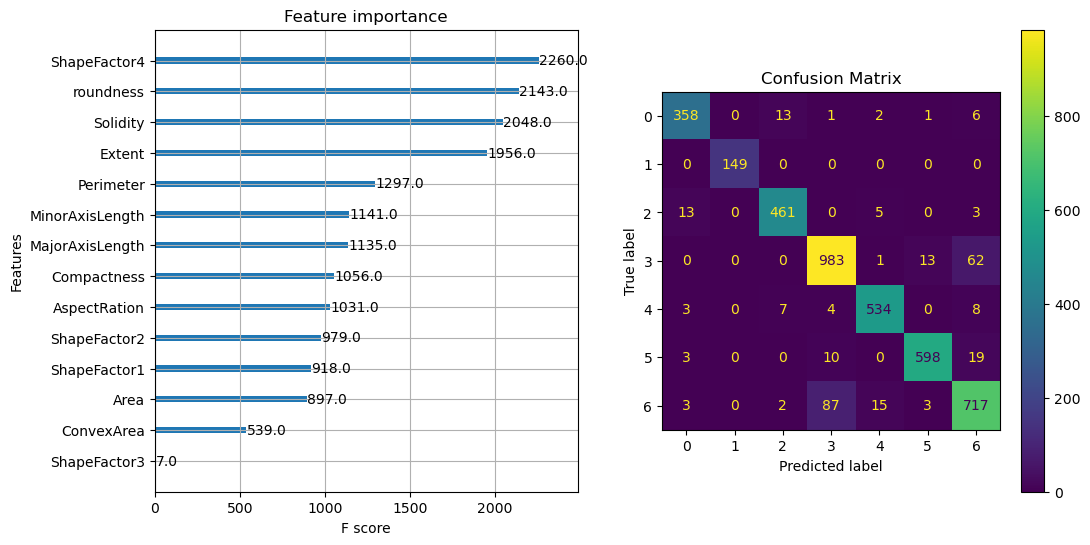

In [29]:
xg_opt_model(learner_df)

The goal of the optimization is to improve the predictive abilities of the learner model. Initially, feature scaling cmobined with handling of class imbalance was attempted to improve the algorithm. Feature scaling is used to stadardize feaures to improve fit based on variable distribution. To handle class imbalance, the imbalance-learn oversampling method called "SMOTE" was applied to oversample minority clases and undersample the majority classes. This implementation resulted in the classification of every bean as a Bombay bean. The next step was to apply hyperparameter tuning.
Additionally, early stopping, and ensemble bagging methods were unsuccessful in improving the model.
To initiate hyperparameter tuning, a search space parameter grid was defined to include a variety of values for new and introduced hyperparameters, including 'learning_rate' and 'max_depth'. Grid search cross-validation was then applied to the model and parameter space to identify the best estimates for the hyperparameters and used to generate the best model of the gradient booster using the best hyperparameters. Grid Search CV evaluates model performance for each combination of hyperparameters defined in a grid. It utilizes cross-validation to assess performance to identify which estimates are more robust in order to reduce risk of overfitting. Additionally, a stratified k-fold was used instead of a classic k-fold to ensure that each fold maintains the distribution of the original dataset to handle any imbalance in the data.
The results were about the same for scores in accuracy and mean accuracy with a about 0.03 increase in log-loss.Precision, recall, and F1-scores for each class remained the same. However, feature importance in model prediction adjusted and improved certain features, namely 'ShapeFactor2', while indicating a diminshed effect from others, like 'ShapeFactor3'. 